In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



import seaborn as sns

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

def quality_report(actual, prediction):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction)
    ))
    

def plot_roc_curve(actual, prediction):
    fpr, tpr, thresholds = roc_curve(actual, prediction)
    auc_score = roc_auc_score(actual, prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [4]:
def final_report(model, X_train, X_test, X_val, y_train, y_test, y_val):
    print("Train quality")
    quality_report(y_train, model.predict(X_train))

    print("\nTest quality")
    quality_report(y_test, model.predict(X_test))

    print("\nValidate quality")
    quality_report(y_val, model.predict(X_val))

    plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    cm = confusion_matrix(y_test, model.predict(X_test))
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGn", cbar=False);

In [5]:
# df = pd.read_csv('./input/v1_first_collection_2021.csv')
df = pd.read_csv('./input/v2_second_collection_2022.csv')

df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [6]:
df.nunique()

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

Наша задача - задача классификации. Для работы оставляем только 5 информативных параметров.

In [7]:
X, y = df[["est_diameter_min", "est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"]], df.iloc[:, -1]

In [8]:
y.value_counts(normalize=True)

hazardous
False    0.902682
True     0.097318
Name: proportion, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [10]:
# стандартизируем
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [11]:
# sm = SMOTE(random_state=42)
sm = SVMSMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [12]:
forest = RandomForestClassifier()

parametrs = {'n_estimators': range(90, 111, 10),
              'max_depth': [3, 6, 11],
              'max_features': ['auto', 'sqrt', 'log2']}

grid_forest = GridSearchCV(forest, parametrs, cv=5, n_jobs=-1)
grid_forest.fit(X_train, y_train)

params_forest = grid_forest.best_params_
grid_forest.best_params_

{'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 90}

После работы GridSearchCV мы изменяем только максимальную глубину, т.к. при max_depth = 2 общий результат уменьшается, но искомый параметр Recall - максимальный.

Train quality
Accuracy: 0.874
Precision: 0.799
Recall: 0.999
f1_score: 0.888

Test quality
Accuracy: 0.773
Precision: 0.299
Recall: 0.993
f1_score: 0.460

Validate quality
Accuracy: 0.773
Precision: 0.298
Recall: 0.987
f1_score: 0.458


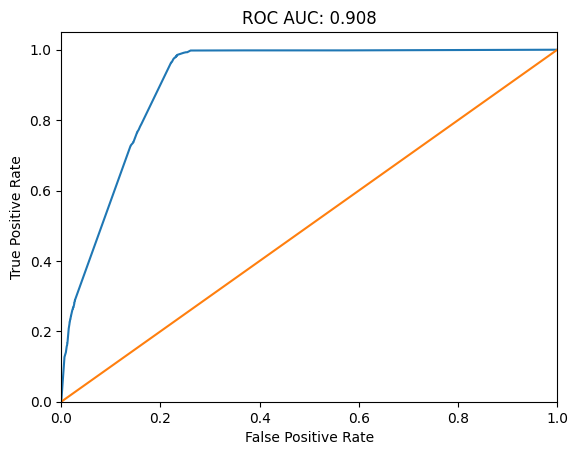

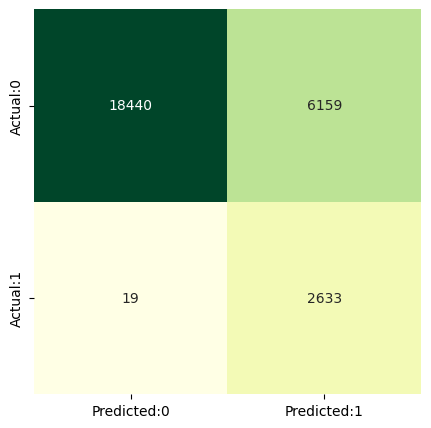

In [13]:
forest = RandomForestClassifier(max_depth = 2, n_estimators = 90, max_features = 'sqrt', class_weight = 'balanced', n_jobs=-1)

forest.fit(X_train, y_train)

final_report(forest, X_train, X_test, X_val, y_train, y_test, y_val)

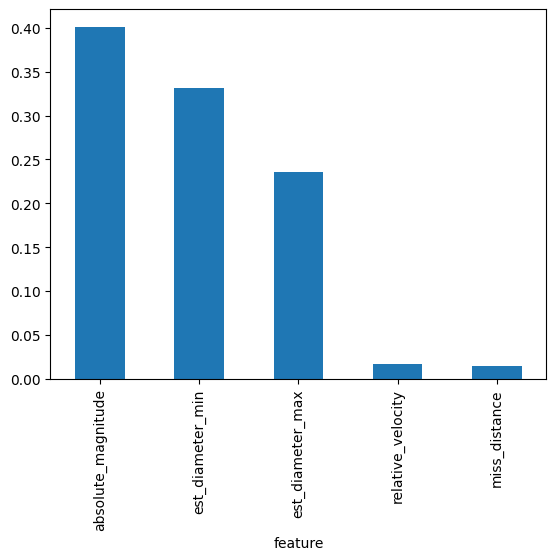

In [14]:
featureImportance = pd.DataFrame({"feature": X.columns, "importance": forest.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

In [15]:
import dill as pickle
with open('model.pkl', 'wb') as file:
	pickle.dump(forest, file)

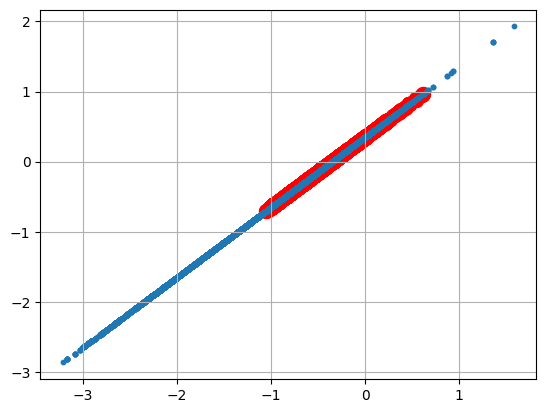

In [29]:
fig, ax = plt.subplots()
ax = plt.scatter(np.log10(df[df['hazardous'] == True]['est_diameter_min']), np.log10(df[df['hazardous'] == True]['est_diameter_max']), s = 100, c = 'r')
ax = plt.scatter(np.log10(df[df['hazardous'] == False]['est_diameter_min']), np.log10(df[df['hazardous'] == False]['est_diameter_max']), s = 10)
plt.grid()
plt.show()

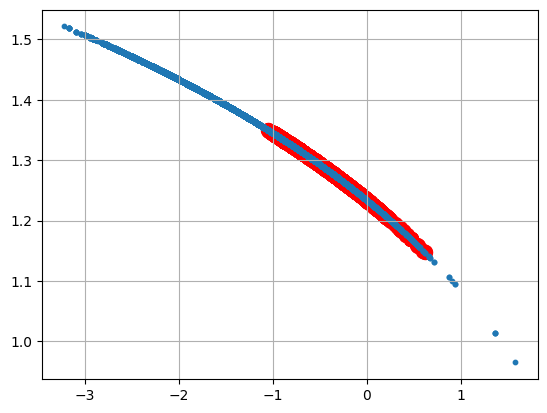

In [28]:
fig, ax = plt.subplots()
ax = plt.scatter(np.log10(df[df['hazardous'] == True]['est_diameter_min']), np.log10(df[df['hazardous'] == True]['absolute_magnitude']), s = 100, c = 'r')
ax = plt.scatter(np.log10(df[df['hazardous'] == False]['est_diameter_min']), np.log10(df[df['hazardous'] == False]['absolute_magnitude']), s = 10)
plt.grid()
plt.show()

В этой задаче выбрали оценочный параметр Recall т.к. нужно минимизировать количество незамеченных опасных небесных тел.

Главные признаки, на которые стоит обращать внимание это оценочный размер небесного тела и абсолютная величина. Предстовляющие опасность астероиды имеют следующие характеристики: минимальный размер в диапазоне от -1 до 0.6 в логарифмическом масштабе, максимальный размер в диапазоне от -0.8 до 1 в логарифмическом масштабе, а абсолютная величина в диапазоне от 1.15 до 1.35 в логарифмическом масштабе.